# Determine expression relationships between constructs

## Imports

In [1]:
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import pathlib
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path

## Find the git root Directory

In [2]:
# Get the current working directory
cwd = Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Seed and Generator for Reproducibility

In [3]:
rnd_val = 0  # Random value for all seeds
rng = np.random.default_rng(seed=rnd_val)  # random number generator

## Define Paths

In [4]:
# Change this filename when plate 4 is available
filename = "Plate_4_sc_norm_fs.parquet"
path = pathlib.Path(
    f"{root_dir}/nf1_painting_repo/3.processing_features/data/feature_selected_data/{filename}"
)

# Add the output path here:
output_path = Path("figures")

# Create the directory if it doesn't exist
output_path.mkdir(parents=True, exist_ok=True)

## Load the data

In [5]:
platedf = pd.read_parquet(path)

## Specify data columns

In [6]:
# The Column that corresponds to the concentration
conc_col = "Metadata_Concentration"

# The Column that corresponds to the construct
construct_col = "Metadata_siRNA"

# Columns that do not contain Metadata
not_meta_cols = [col for col in platedf.columns if "Metadata" not in col]

## Get cells that only contains NF1 siRNA constructs

In [7]:
platedf[construct_col].fillna(value="None", inplace=True)

platefilt = platedf[construct_col].str.contains("NF1")

platedf = platedf.loc[platefilt]

## Column for filtering correlation data

In [8]:
platedf["Metadata_group"] = platedf.apply(
    lambda row: f"{row['Metadata_Well']}_{row[conc_col]}_{row[construct_col]}", axis=1
)

## Find within well correlations
This will find the correlation values for each consctruct and concentration of siRNA

In [9]:
inwell = []
inwell = defaultdict(list)

# Duplicates do not have to be filtered, since correlations across plates are not considered
for group in platedf["Metadata_group"].unique():
    # Find all cells that correspond to the specific (well, siRNA concentration, siRNA construct) group
    welldf = platedf.loc[(platedf["Metadata_group"] == group)]

    dfrow = welldf.iloc[0]

    # The concentration of the siRNA construct for this group
    conc = dfrow[conc_col]

    # The construct of the siRNA construct for this group
    construct = dfrow[construct_col]

    # The well dataframe for this group
    welldf = platedf.loc[platedf["Metadata_group"] == group]

    # If there are no samples for a particular group, ignore it
    if len(welldf) == 0:
        continue

    # Get the well dataframe that does not have metadata columns to compute correlations
    welldf = welldf[not_meta_cols]

    # Get a correlation matrix between each cell pair and covert it to a numpy array
    corr_mat = welldf.T.corr().values

    # Get the values that correspond to the lower triangle excluding the main diagonal
    idx = np.tril_indices(corr_mat.shape[0], k=-1)
    corr_vec = corr_mat[idx]

    # Append correlations in a list (order doesn't matter in this case)
    inwell[f"{construct}_{conc}"].append(corr_vec)

In [10]:
# Concatenate all correlations calculated within each well
inwell = {
    sirna_group: np.concatenate(corr_vecs) for sirna_group, corr_vecs in inwell.items()
}

## Compute entire correlation matrix

In [11]:
# Remove metadata columns and Compute all correlations for all cells
allcorr = platedf[not_meta_cols].T.corr()

# Set all of the correlation coeffients between the same cells as nans
allcorr.values[np.diag_indices_from(allcorr)] = np.nan

## Function for same and different construct correlations

In [12]:
def get_correlations(same_construct):
    """
    Calculates the cross correlations between cells across wells using the same siRNA concentrations for either the same constructs or different constructs.

    Parameters
    ----------
    same_construct: Boolean
        Whether to consider different construct or the same constructs with calculate cross correlations between cells

    Returns
    -------
    transwell: Dictionary
    Contains the cell correlation vectors for each group
    """

    # Groups that have already been considered
    tried_wells = []

    # Holds correlations for siRNA constructs and concentrations
    transwell = defaultdict(list)

    for group in platedf["Metadata_group"].unique():
        # Find all cells that correspond to the specific (well, siRNA concentration, siRNA construct) group
        welldf = platedf.loc[(platedf["Metadata_group"] == group)]

        dfrow = welldf.iloc[0]

        # The well for this group
        well = dfrow["Metadata_Well"]

        # The concentration of the siRNA construct for this group
        conc = dfrow[conc_col]

        # The construct of the siRNA construct for this group
        construct = dfrow[construct_col]

        if same_construct:
            # Cells that are used to perform cross correlation. Only cells that have not been cross correlated with the same siRNA construct, the same siRNA concentration from different wells are considered.
            other_welldf = platedf.loc[
                (platedf[conc_col] == conc)
                & (platedf[construct_col] == construct)
                & (platedf["Metadata_Well"] != well)
                & ~(platedf["Metadata_Well"].isin(tried_wells))
            ]

        else:
            # Cells that are used to perform cross correlation. Cells with different siRNA constructs, and the same siRNA concentration from different wells are considered. Cells that have already been correlated are not tracked, since groups are compared independently
            other_welldf = platedf.loc[
                (platedf[conc_col] == conc)
                & (platedf[construct_col] != construct)
                & (platedf["Metadata_Well"] != well)
            ]

        # If there are no cells from either of these groups to cross correlate, the next group is considered
        if len(welldf) == 0 or len(other_welldf) == 0:
            continue

        # Get the indices corresponding to each cell for the two dataframes to compare, where the indices are also used to reference the columns
        welldf_idx = welldf[not_meta_cols].index
        other_welldf_idx = other_welldf[not_meta_cols].index

        # Find the correlation coefficients from the indices
        corr_df = allcorr.loc[welldf_idx, other_welldf_idx]

        # Convert the correlation values and flatten them
        corr_vec = corr_df.values.flatten()

        # There shouldn't be nans, but remove numpy nans from each correlation vector if nans exist
        nan_idx = np.isnan(corr_vec)
        corr_vec = corr_vec[~nan_idx]

        # Keep track of the wells used for the correlation
        tried_wells.append(well)

        # Record the correlations constructs and SiRNA concentrations
        transwell[f"{construct}_{conc}"].append(corr_vec)

    return transwell

## Get the correlations for the same constructs

In [13]:
same_transwell = get_correlations(same_construct=True)

# Concatenate all correlation values in one numpy array for each group
same_construct = {
    sirna_group: np.concatenate(corr_vecs)
    for sirna_group, corr_vecs in same_transwell.items()
}

## Get the correlations for different constructs

In [14]:
diff_transwell = get_correlations(same_construct=False)

# Concatenate all correlation values in one numpy array for each group
diff_construct = {
    sirna_group: np.concatenate(corr_vecs)
    for sirna_group, corr_vecs in diff_transwell.items()
}

## Prepare data for plotting

In [15]:
# Get unique siRNA construct concentrations
pos_covar = platedf[conc_col].unique()

# Get unique siRNA constructs
pos_const = platedf[construct_col].unique()

# Define the domain for plotting
xs = np.linspace(-1, 1, 500)

# Define correlation distributions in a dictionary
corr_dists = {
    "Within Well": inwell,
    "Same Construct Across Wells": same_construct,
    "Different Construct Across Wells": diff_construct,
}

## Plot PDF Curves

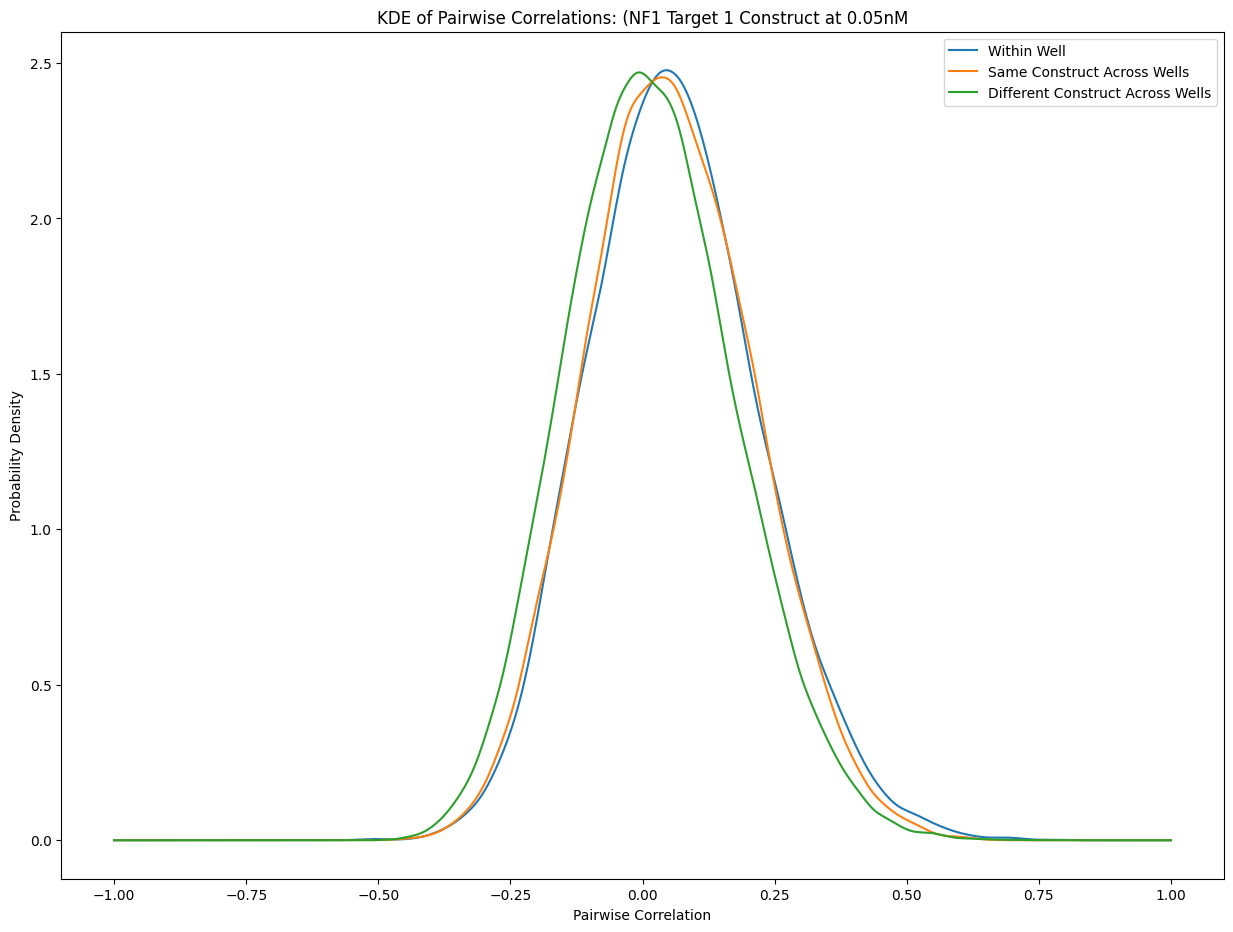

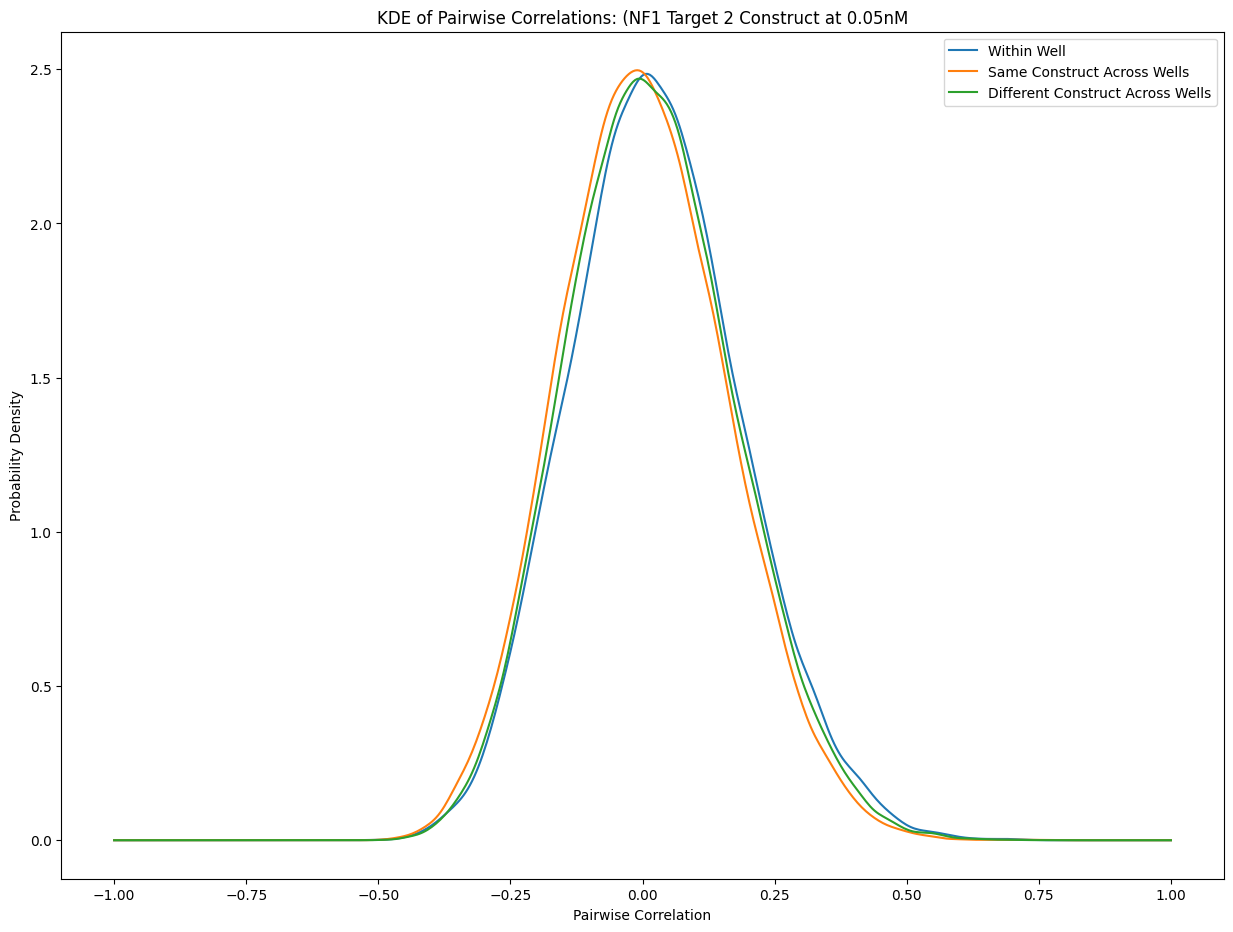

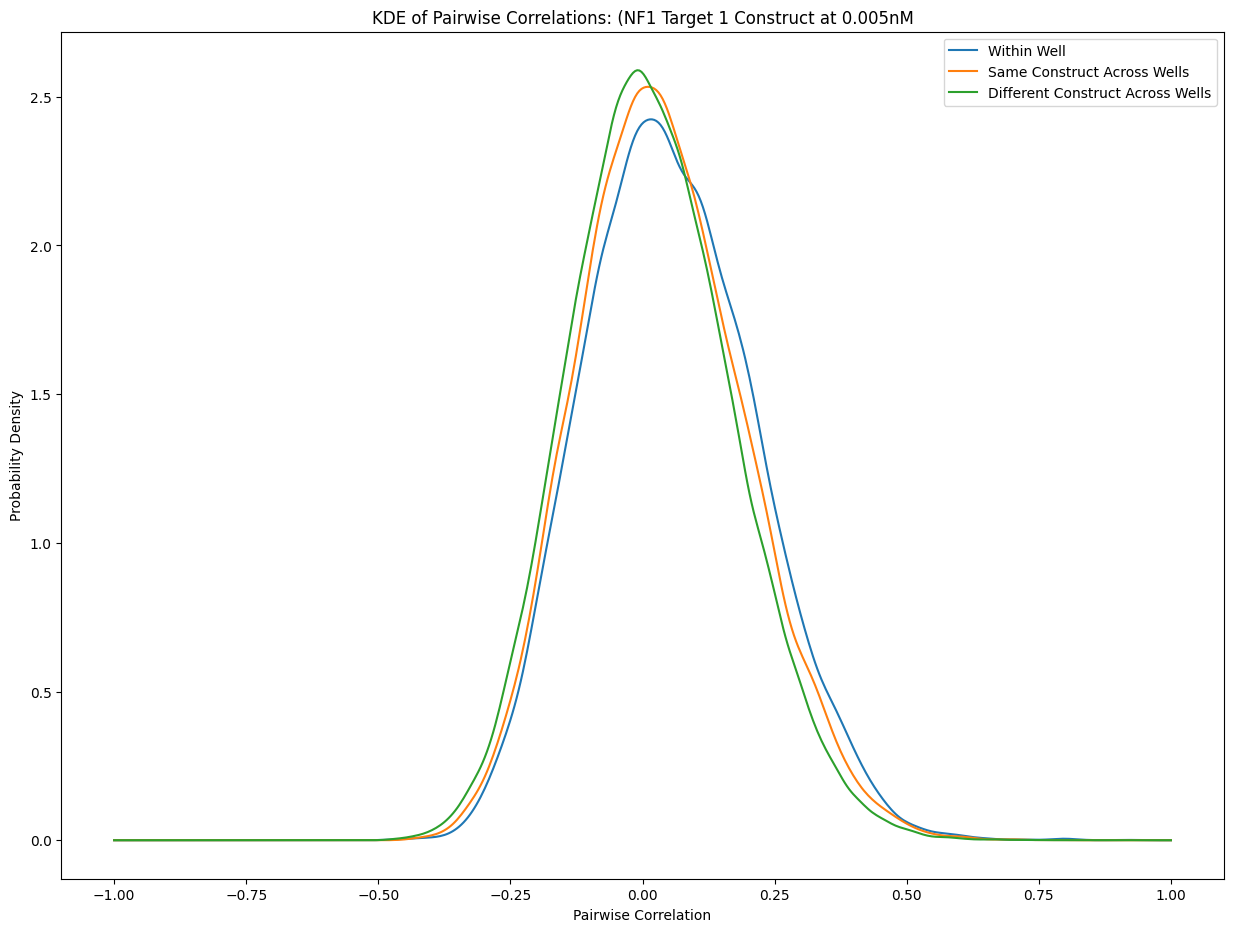

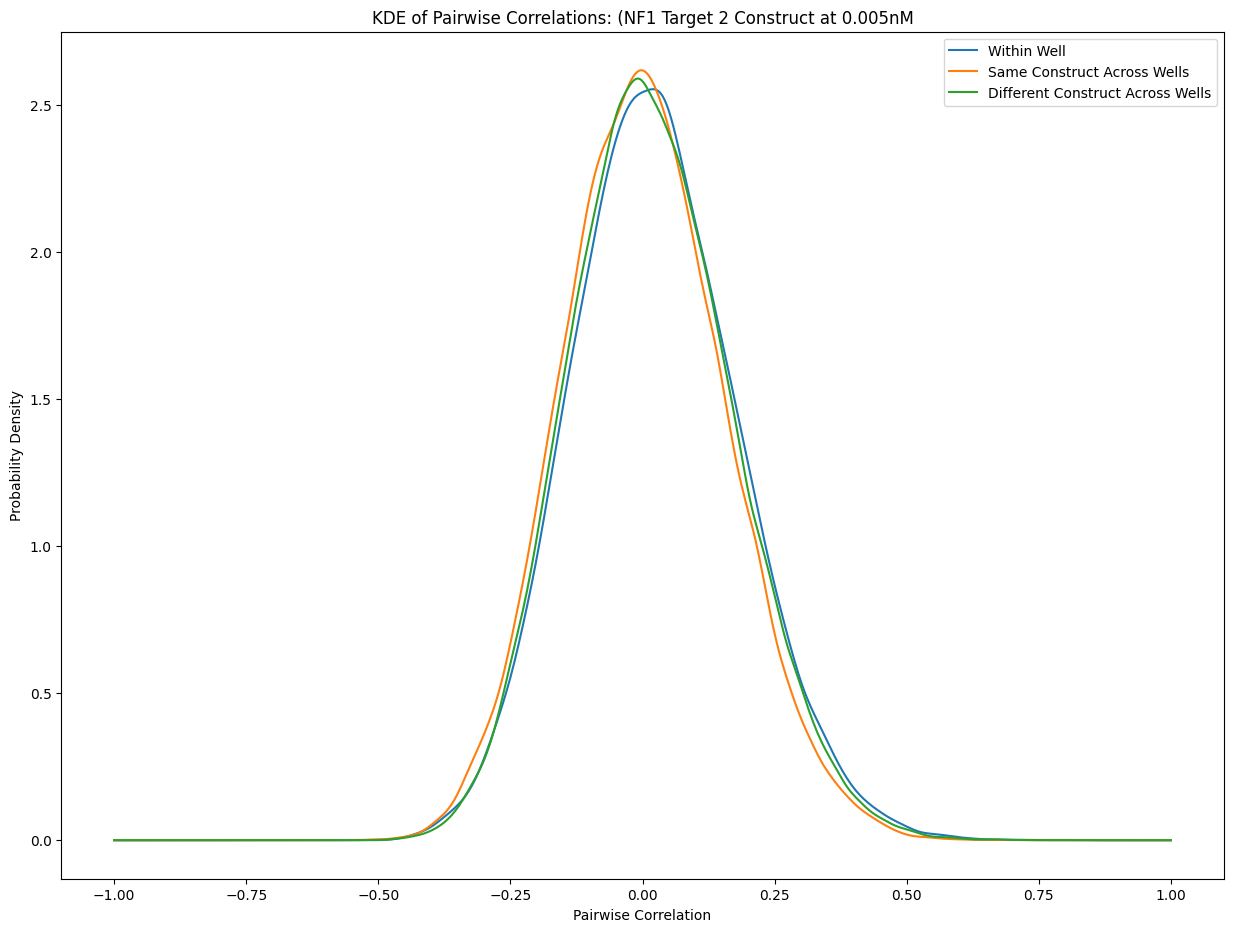

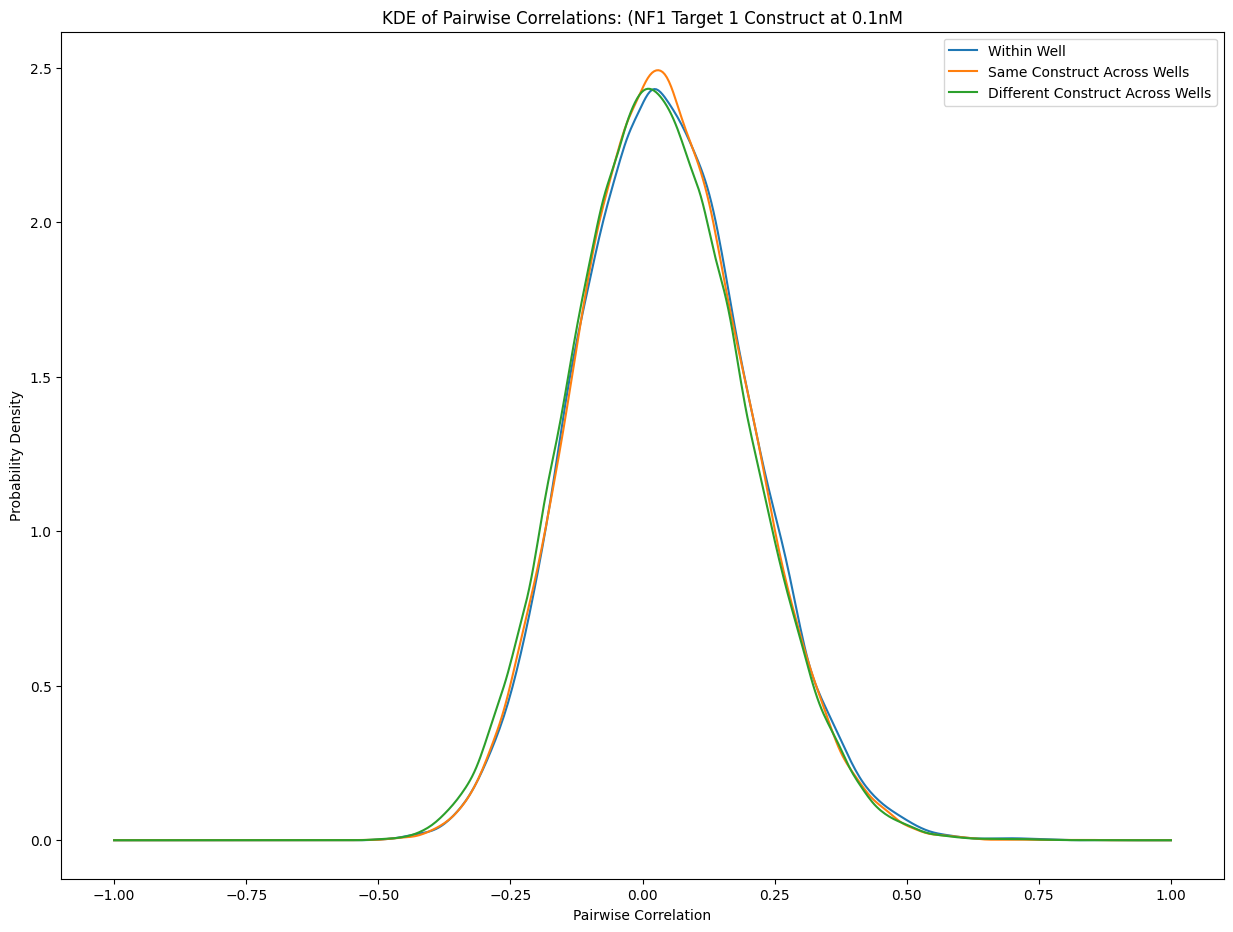

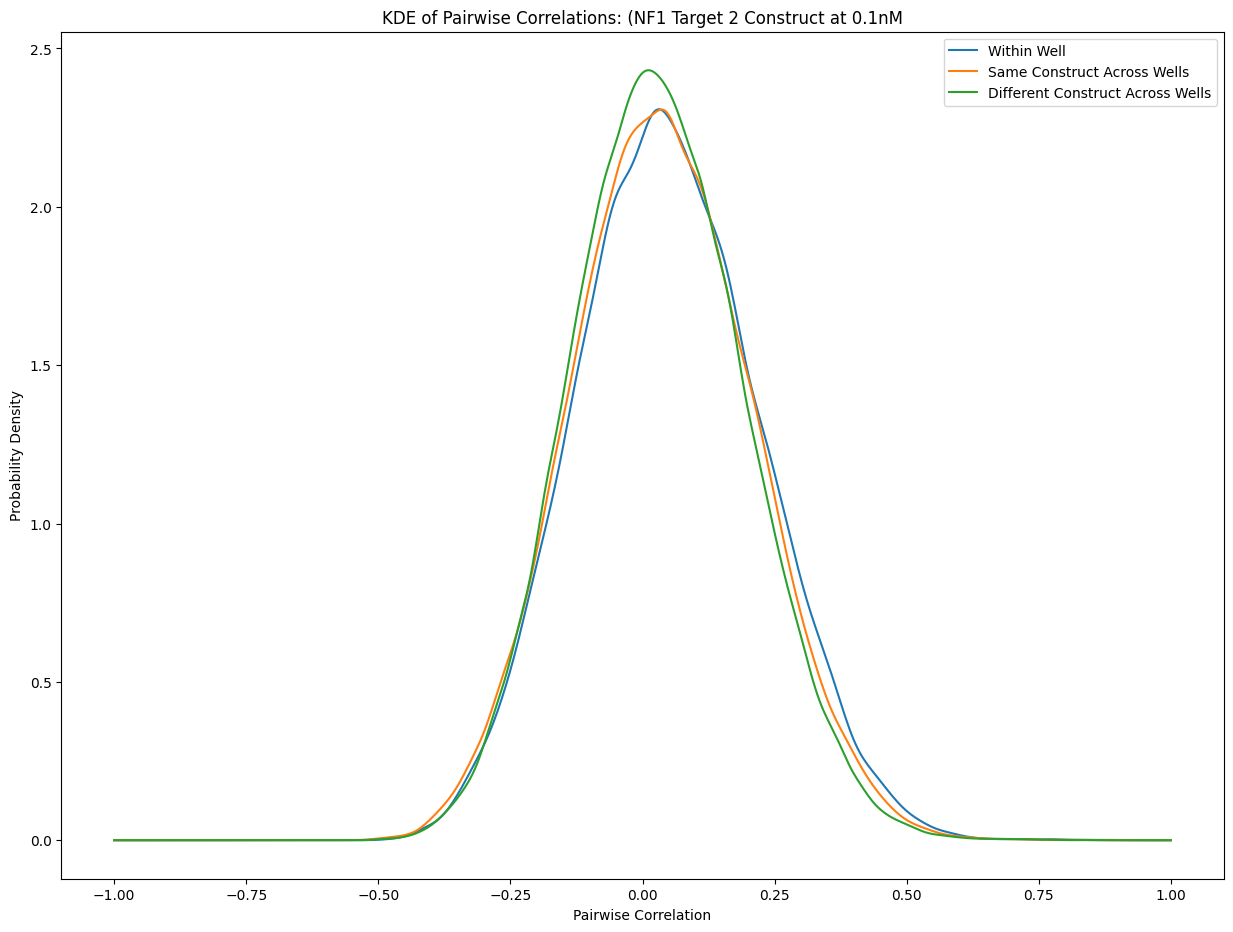

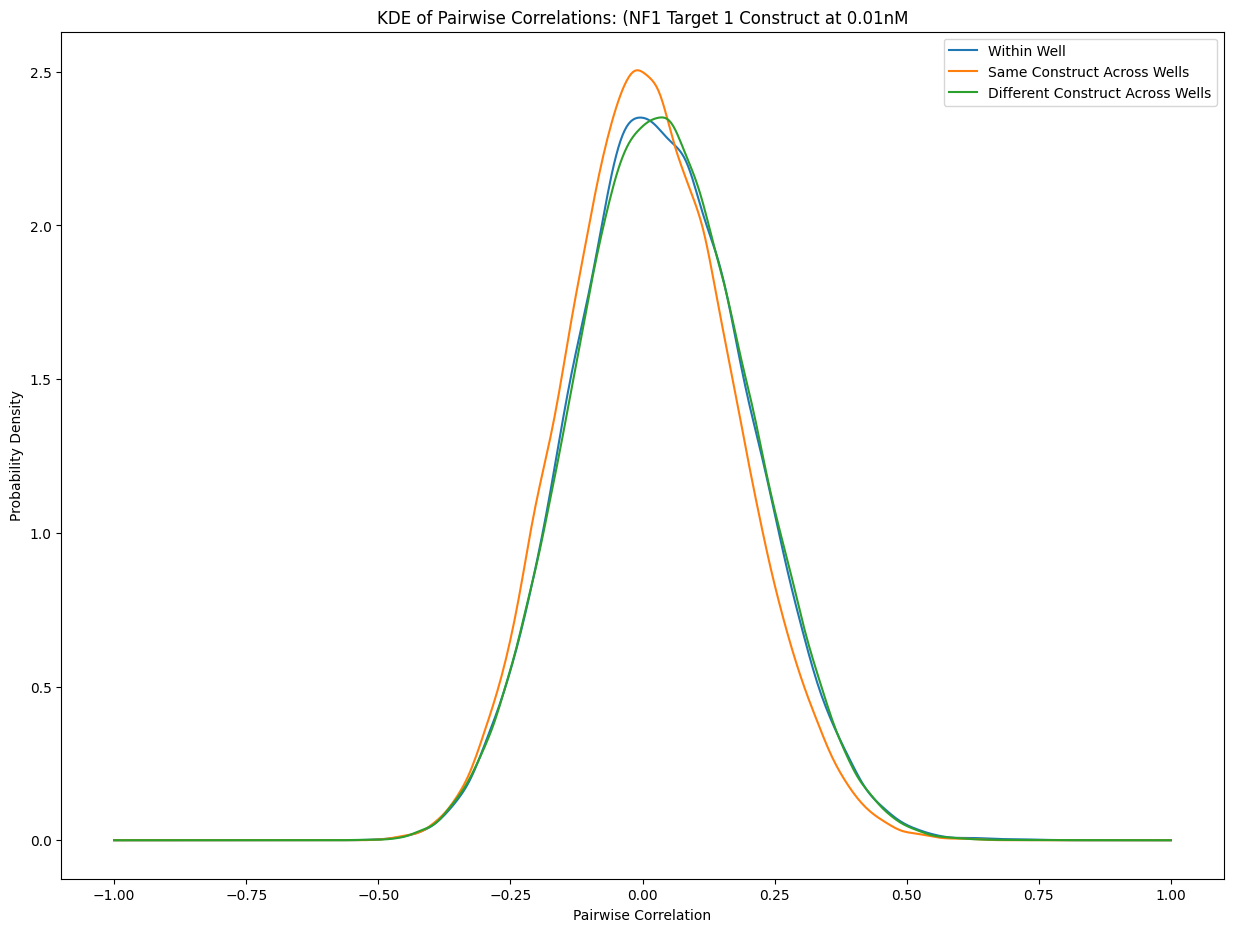

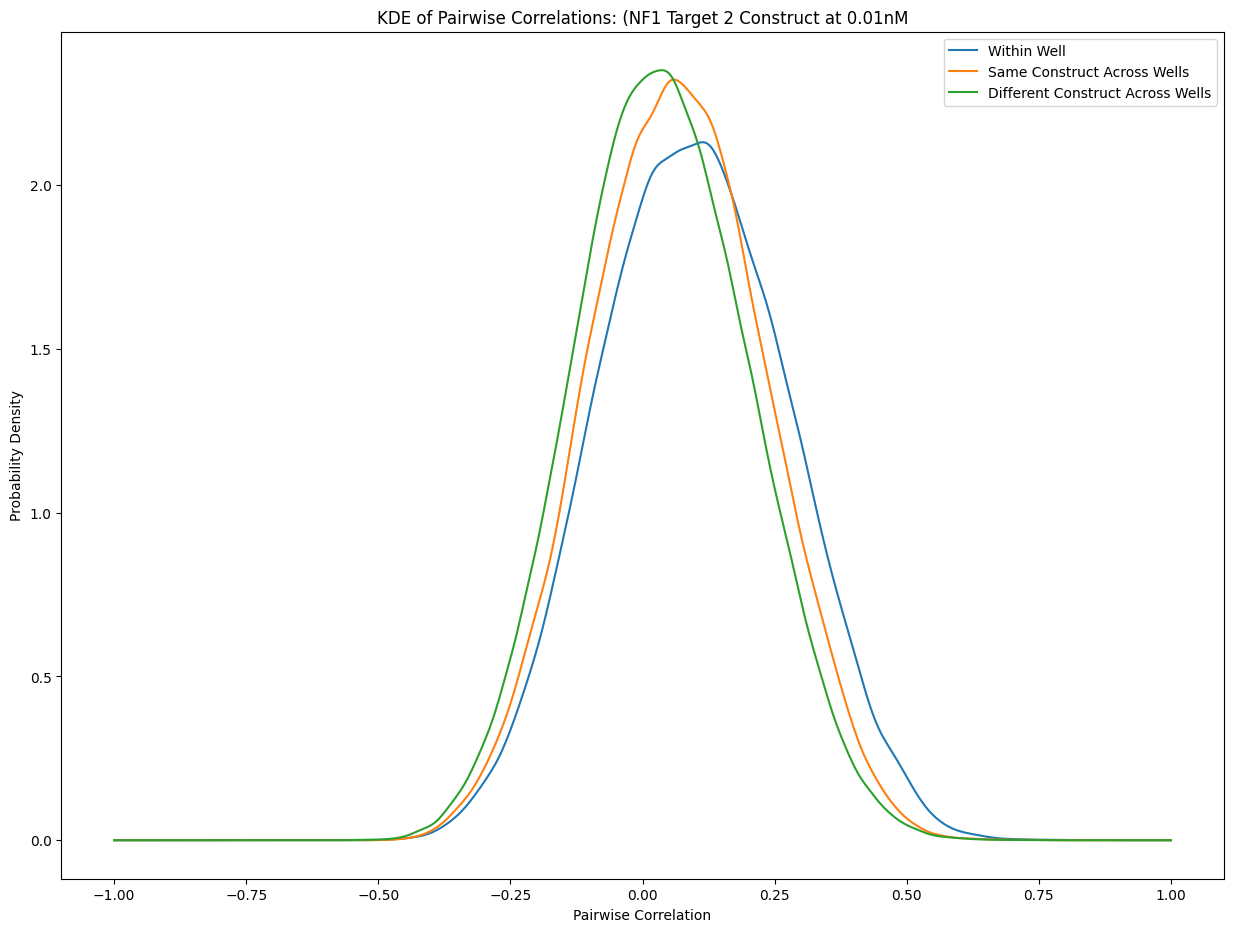

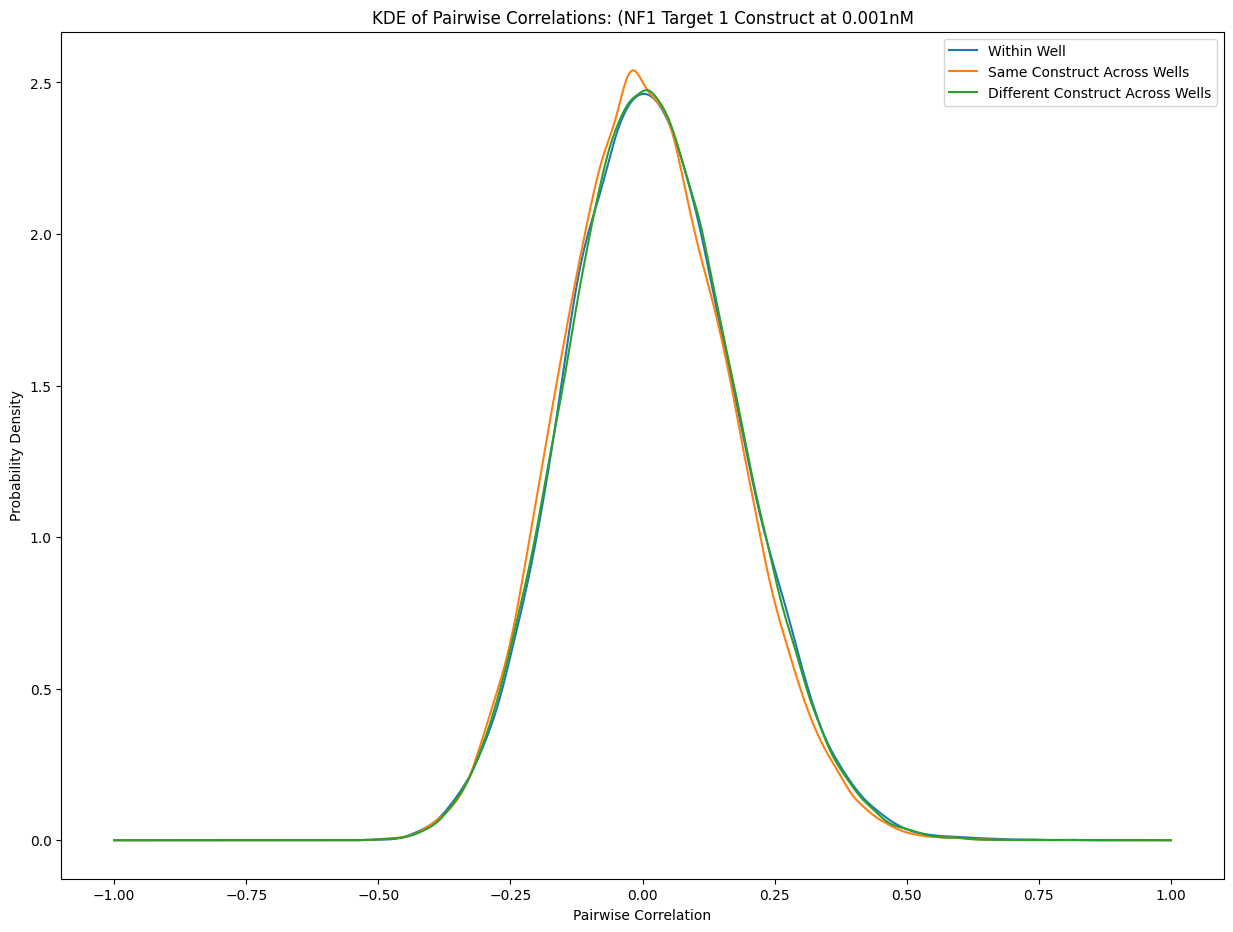

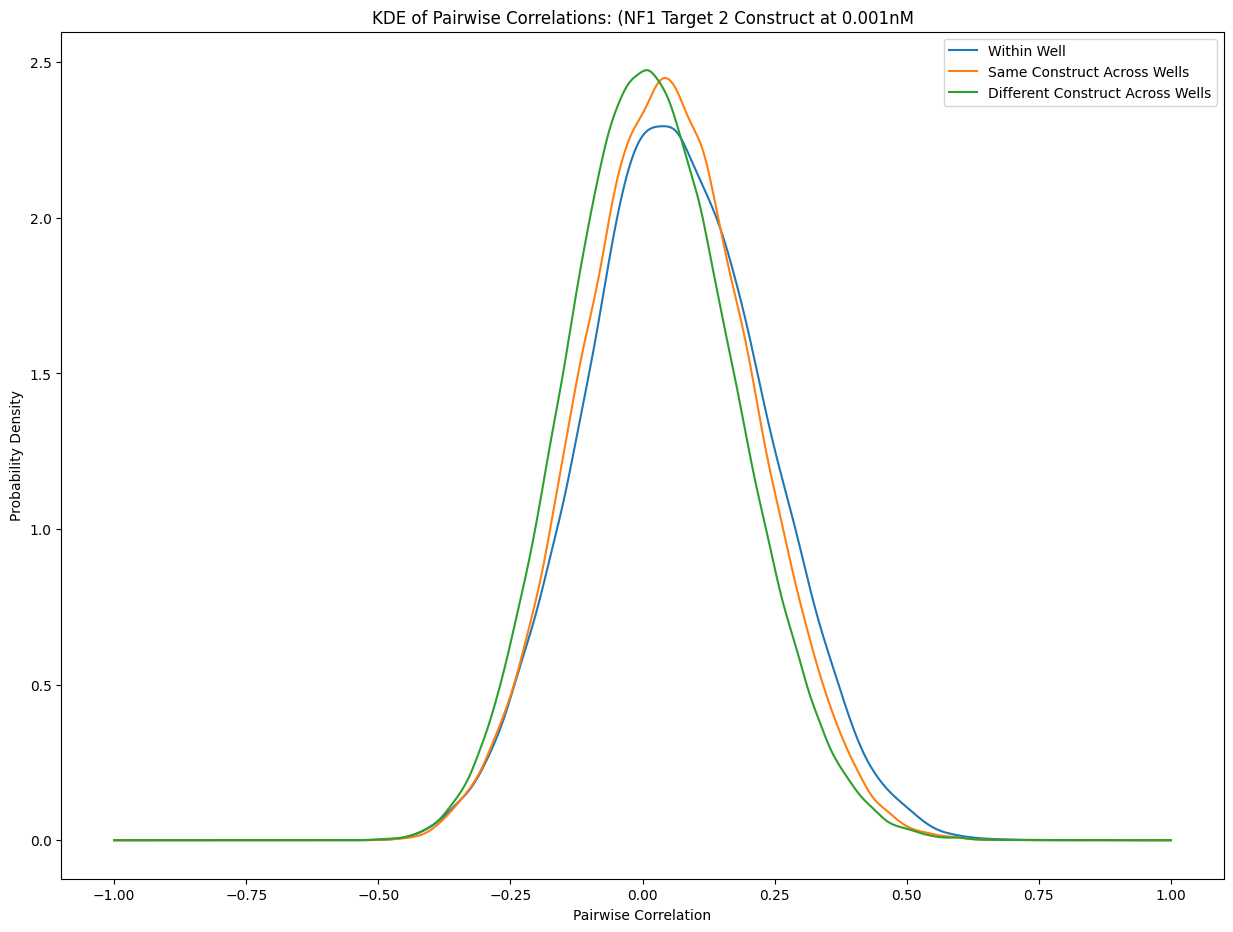

In [16]:
# Iterate through each covariate group (just concentration in this case)
for row, group in enumerate(pos_covar):
    # Iterate through each siRNA construct
    for const in pos_const:
        fig, ax = plt.subplots(figsize=(15, 11))

        # Define each combination to reference correlation distributions
        panel = f"{const}_{group}"

        # Plot each distribution for a given panel
        for dlabel, dist in corr_dists.items():
            # Get the kde distribtion for the correlation data
            w_x = dist[panel]
            w_density = gaussian_kde(w_x)
            w_y = w_density(xs)

            ax.plot(xs, w_y, label=dlabel)

        ax.set_xlabel("Pairwise Correlation")
        ax.set_ylabel("Probability Density")
        ax.legend()
        ax.set_title(panel)
        ax.set_title(f"KDE of Pairwise Correlations: ({const} Construct at {group}nM")
        fig.savefig(f"{output_path}/pdf_{panel}.png")

# Show the plot
plt.show()